In [52]:
model_checkpoint = "microsoft/swinv2-base-patch4-window12to16-192to256-22kto1k-ft" # pre-trained model from which to fine-tune
batch_size = 4 # batch size for training and evaluation

In [53]:
!pip install -q datasets transformers

In [29]:
from huggingface_hub import notebook_login

notebook_login()

In [30]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [31]:
from transformers.utils import send_example_telemetry

send_example_telemetry("image_classification_notebook", framework="pytorch")

### Loading the dataset

In [32]:
from datasets import load_dataset 

# load a custom dataset from local/remote files or folders using the ImageFolder feature

dataset = load_dataset("imagefolder", data_dir="/kaggle/input/thermography-images-of-diabetic-foot/ThermoDataBase", split="train")
dataset = dataset.train_test_split(test_size=0.2)

Resolving data files:   0%|          | 0/1444 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/422 [00:00<?, ?it/s]

In [33]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1155
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 289
    })
})

In [34]:
from datasets import load_metric

metric = load_metric("accuracy")

/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [35]:
example = dataset["train"][10]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'label': 0}

In [36]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['Control Group', 'DM Group'], id=None)}

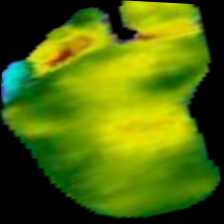

In [37]:
example['image']

In [38]:
example['label']

0

In [39]:
dataset["train"].features["label"]

ClassLabel(names=['Control Group', 'DM Group'], id=None)

In [40]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[1]

'DM Group'

### Preprocessing the data

In [41]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor 

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 256,
    "width": 256
  }
}

In [42]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [
        val_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

In [43]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [44]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [45]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'label': 1,
 'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ...,  0.7077,  0.7077,  0.7248],
          [-2.1179, -2.1179, -2.1179,  ...,  0.7077,  0.7077,  0.7248],
          [-2.1179, -2.1179, -2.1179,  ...,  0.7077,  0.7077,  0.7077],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -0.3375, -0.3200, -0.3025],
          [-2.0357, -2.0357, -2.0357,  ..., -0.3200, -0.3025, -0.2850],
          [-2.0357, -2.0357, -2.0357,  ..., -0.2675, -0.2675, -0.2675],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],


### Training the model

In [46]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window12to16-192to256-22kto1k-ft and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-footulcer",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [55]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [56]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [58]:
import torch
torch.cuda.empty_cache()

In [59]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [60]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.425000,0.276933,0.879310
2,0.318200,0.054683,0.982759
3,0.205300,0.028554,0.991379
4,0.289200,0.016699,0.991379
5,0.177400,0.001330,1.000000


***** train metrics *****
  epoch                    =         5.0
  total_flos               = 495949244GF
  train_loss               =      0.2897
  train_runtime            =  0:05:13.96
  train_samples_per_second =      16.547
  train_steps_per_second   =       1.035


In [61]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =        1.0
  eval_loss               =     0.0013
  eval_runtime            = 0:00:02.31
  eval_samples_per_second =     50.156
  eval_steps_per_second   =     12.539


In [62]:
trainer.push_to_hub()

events.out.tfevents.1714504578.aa80023fdf35.34.2:   0%|          | 0.00/411 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Nitish2801/swinv2-base-patch4-window12to16-192to256-22kto1k-ft-finetuned-footulcer/commit/dc56829e98ed58000c5428031eaf7a81159d3312', commit_message='End of training', commit_description='', oid='dc56829e98ed58000c5428031eaf7a81159d3312', pr_url=None, pr_revision=None, pr_num=None)

## Inference

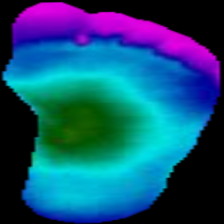

In [63]:
from PIL import Image
import requests

file = "/kaggle/input/thermography-images-of-diabetic-foot/ThermoDataBase/val/Control Group/CG001_M_L-rotated1-rotated2.png"
image = Image.open(file)
image

In [64]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "Nitish2801/swinv2-base-patch4-window12to16-192to256-22kto1k-ft-finetuned-footulcer"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

preprocessor_config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/348M [00:00<?, ?B/s]

In [65]:
# prepare image for the model
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 256, 256])


In [66]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [67]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Control Group


## Pipeline API

In [68]:
from transformers import pipeline

pipe = pipeline("image-classification", "Nitish2801/swinv2-base-patch4-window12to16-192to256-22kto1k-ft-finetuned-footulcer")

In [69]:
pipe(image)

[{'label': 'Control Group', 'score': 0.9999765157699585},
 {'label': 'DM Group', 'score': 2.344212043681182e-05}]

In [70]:
pipe = pipeline("image-classification", 
                model=model,
                feature_extractor=image_processor)

In [ ]:
pipe(image)